<a href="https://colab.research.google.com/github/rafiag/Hate-Speech-Classification/blob/main/Bahasa_Indonesia_Hate_Speech_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining with Python

Text mining is the process of extracting the implicit knowledge from textual data. Because the implicit knowledge which is the output of text mining does not exist in the given storage, it should be distinguished from the information which is retrieved from the storage. Unlike regular machine learning problems, text mining have it's own challenges. One of those challenges is how to transform our text data from a set of words to something meaningful and easy for the computer to understand. In this notebook I will try to demonstrate one form of text mining, text classification, to classify if a tweet is hate speech or not.

Before we start, we will load some libraries we will be using in the code cell below.

In [1]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')
sns.set(rc={'figure.facecolor':'white'})
sns.set_palette('Accent')

# Loading Data

The dataset I will be using is originally taken from ['The Dataset for Hate Speech Detection in the Indonesian Language (Bahasa Indonesia)'](https://github.com/ialfina/id-hatespeech-detection/). I modified the data from TSV to CSV and uploaded it into my GitHub repos for easier load process.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rafiag/Hate-Speech-Classification/main/hate_speech_dataset.csv')

print(df.shape)
df.head()

(713, 2)


,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


# Text Pre-Processing

Before we can begin to create our model we first need to  pre-process the data. This step ensure that our model will receive a good data to learn from, as they said "a model is only as good as it's data". This is especially true for our text dataset which originated from Twitter, which can really be messy if we didn't clean it before passing it into the model.

As I explained above, this process will be different from doing data pre-processing on structured data.  The data pre-processing will be divided into few steps as explained below.

## Checking Class Distribution

Another important thing to make sure before feeding our data into the model is the class distribution of the data. In our case where the expected class are divided into two outcome, 'HS' and 'No_HS', a class distribution of 50:50 can be considered ideal.

In [3]:
df['Label'].value_counts()

Non_HS    453
HS        260
Name: Label, dtype: int64

Look likes our class distribution isn't exactly ideal. To solve this problem we can try to either undersample (removing data from majority class) or oversampling (create new data for the minority class). In this notebook I won't do either one of those beacause I personally think the imbalance isn't that bad. [Here](https://towardsdatascience.com/how-i-handled-imbalanced-text-data-ba9b757ab1d8) is a good reference how to handle imbalanced text data if you are interested in doing so.

## Text Cleaning

On the next few cell block we will try to clean our data into a more usable data for our model to learn from. Before we do that, let's make a copy of our original dataframe to avoid messing with the original dataset by using the pandas `.copy()` function.



In [4]:
# Copy original dataframe to avoid messing the original data
df1 = df.copy()

### Tokenize

The first step we will do is tokenizing our data. Tokenizing data simply means that we will separate our data from sentence into a list of words, for example:

|  | Result |
|-|-|
| Original | @JohnDoe Hai, apa kabar? Aku baru bergabung ke #twitter nih |
| Tokenize | ['@JohnDoe', 'Hai', 'apa', 'kabar', 'aku', 'baru', 'bergabung', 'ke', '#twitter', 'nih'] |

In this step I will be using a function I wrote some times ago. The function will be utilizing the NLTK tokenizer to also include function to remove any punctuation from the data.

In [5]:
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

def tokenizeWords(s, remove_punctuation=True):
    if remove_punctuation == True:
        tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
        clean_words = tokenizer.tokenize(s)
    else:
        clean_words = nltk.word_tokenize(s)
    return clean_words

# Tokenize words
df1['tokens'] = df1['Tweet'].apply(tokenizeWords)

df1.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Label,Tweet,tokens
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........"


### Remove mentions, URLs, special chars, and number

This second step is a special one, because in most case you are not really required to do this. But in this case since our data is from Twitter we will have lot of @mention, #hashtags, URLs, and other things that will just clutter our data and won't help it's performance.

|  | Result |
|-|-|
| Tokenize | ['@JohnDoe', 'Hai', 'apa', 'kabar', 'aku', 'baru', 'bergabung', 'ke', '#twitter', 'nih'] |
| Remove Useless Text | ['Hai', 'apa', 'kabar', 'aku', 'baru', 'bergabung', 'ke', 'nih'] |

Below I wrote a new function involving the re libraries to extract pattern from text using regular expression, which is really useful to remove the aforementioned elements.

In [6]:
import re

def removeUselessText(tokens):
    new_tokens = []
    for t in tokens:
        # Remove hashtag
        if not t.startswith('#'):
            # Remove leading & trailing whitespace
            t = t.strip()
            
            # Remove mention
            t = re.sub('@[^\s]+', '', t)

            # Remove urls
            t = re.sub(r'\\/', '/', t) # replace escaped character
            t = re.sub(r'(https?://\S+)', '', t) # remove urls

            # Remove special character and number
            t = re.sub('[^a-zA-Z\s]', '', t)

            new_tokens.append(t)

    return [token for token in new_tokens if token]

df1['no_useless'] = df1['tokens'].apply(removeUselessText)

df1.head()

,Label,Tweet,tokens,no_useless
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http..."


### Stemming

Onto the third step, we will stem all word into it's base form by removing the prefix and suffix of the words.

|  | Result |
|-|-|
| Remove Useless Text | ['Hai', 'apa', 'kabar', 'aku', 'baru', 'bergabung', 'ke', 'nih'] |
| Stemming | ['Hai', 'apa', 'kabar', 'aku', 'baru', 'gabung', 'ke', 'nih'] |

In this step I will be using Bahasa Indonesia stemmer from Sastrawi libraries.

*Note: this step may take a few minutes and is a known performance problem from Sastrawi*

In [7]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemmSentence(tokens):
    # Initiate Sastrawi stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    return [stemmer.stem(t) for t in tokens]

df1['stemmed'] = df1['no_useless'].apply(stemmSentence)

df1.head()

,Label,Tweet,tokens,no_useless,stemmed
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno...","[rt, fadli, zon, minta, mendagri, segera, nona..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang...","[rt, mereka, terus, luka, aksi, dalam, rangka,..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http..."


### Replace Slang Words

One other thing to take note of when dealing with text data in Bahasa Indonesia is slang words, Indonesian people loves to use slang, especially on the internet. Unfortunately, I am not able to found any ready-to-use Python libraries to help with this problem. 

Instead what I will do is use the slangword dictionary from [dhitology's GitHub repos](https://github.com/dhitology) and convert it to Python dictionaries to make replacing our data easier. Granted, this is not a really good solution since there is still some slang words in our dataset that's not included in the dictionary, but (personally) I think it's good enough.

If you are interested in learning a better approach to solve this problem here is a good [article](https://medium.com/kata-engineering/mengubah-bahasa-indonesia-informal-menjadi-baku-menggunakan-kecerdasan-buatan-4c6317b00ea5) about a new methodology to transform text from informal Bahasa Indonesia to a more formal form.

In [8]:
# Load slang data
slang_df = pd.read_csv('https://raw.githubusercontent.com/dhitology/sma-r/master/data/support/Slangword.csv')

# Remove trailing whitespace
slang_df['old'] = slang_df['old'].apply(lambda x: x.strip())
slang_df['new'] = slang_df['new'].apply(lambda x: x.strip())

# Transform into key value paris in a dict
slang_dict = {}
for idx, row in slang_df.iterrows():
    slang_dict.update({row['old']: row['new']})

def replaceSlang(tokens):
    # iterate through tokens
    for i, word in enumerate(tokens):
        # check if token is in slang dictionary
        try:
            tokens[i] = slang_dict[word]
        # if token is not slang pass
        except KeyError:
            pass
    return tokens

df1['no_slang'] = df1['stemmed'].apply(replaceSlang)

df1.head()

,Label,Tweet,tokens,no_useless,stemmed,no_slang
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno...","[rt, fadli, zon, minta, mendagri, segera, nona...","[rt, fadli, zon, minta, mendagri, segera, nona..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[rt, mereka, terus, luka, aksi, dalam, rangka,..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http..."


### Remove Stop Words

For the last step of our text cleaning we will remove stop words (meaningless word) from our data. I will use the Bahasa Indonesia stop words list provided in the spacy libraries as the reference on which word to remove from our data. In this step I will also remove any word that's less than 3 characters long in order to trim our data and increase our training speed. 

In [9]:
def removeStopWords(tokens, min_len=3):
    from spacy.lang.id.stop_words import STOP_WORDS

    return [t for t in tokens if t not in STOP_WORDS and len(t)>min_len]

df1['no_stop'] = df1['no_slang'].apply(removeStopWords)

df1.head()

,Label,Tweet,tokens,no_useless,stemmed,no_slang,no_stop
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno...","[rt, fadli, zon, minta, mendagri, segera, nona...","[rt, fadli, zon, minta, mendagri, segera, nona...","[fadli, mendagri, nonaktif, ahok, gubernur, ht..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, gurbernur, laku, keras, perempuan, buk..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[waspada, palsu, kawal, pilkada, https, tcoooo..."


## Encoding Target Value

The final step of our text cleaning is to join together our text data into a single string instead a list of string which later will be fitted into a TFIDF vectorizer. In this code cell we will also encode our label into a numeric value, 1 if it's a hate speech, and 0 if it is not a hate speech.

In [10]:
# Combine cleaned text into one string
df1['ready'] = df1['no_stop'].apply(lambda x: ' '.join(x))

# Encode target labels
df1['Label'] = df['Label'].apply(lambda x: 1 if x == 'HS' else 0)

df1.head()

,Label,Tweet,tokens,no_useless,stemmed,no_slang,no_stop,ready
0,0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno...","[rt, fadli, zon, minta, mendagri, segera, nona...","[rt, fadli, zon, minta, mendagri, segera, nona...","[fadli, mendagri, nonaktif, ahok, gubernur, ht...",fadli mendagri nonaktif ahok gubernur https tc...
1,0,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[luka, aksi, rangka, penjara, ahok, ahok, gaga...",luka aksi rangka penjara ahok ahok gagal pilkada
2,0,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, gurbernur, laku, keras, perempuan, buk...",sylvi gurbernur laku keras perempuan bukti fot...
3,0,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be...",ahmad dhani puas debat pilkada jalan bekas htt...
4,0,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[waspada, palsu, kawal, pilkada, https, tcoooo...",waspada palsu kawal pilkada https tcooooerqvsm


## Splitting Dataset

To finish up our pre-processing we will split our dataset into training data and testing data. Because we have a quite small dataset (about 700 rows), we will use 80% of our dataset as training set in order to give our model a little bit more data to learn from.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df1['ready'], 
                                                    df1['Label'], 
                                                    random_state=0,
                                                    train_size=0.8)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (570,)
Shape of X_test: (143,)


# Feature Extraction

Going back to the earlier part of the notebook, remember how I said the unique challenge in text mining is how to transform our text data into something that can be understand by the computer? Well, we are finally going to deal with that problem here. There are some method available to transform our text data into a numerical data, such as:

*   One Hot Encoding
*   CountVectorizer
*   TFIDF
*   Word Embedding

In this notebook I will use the TF-IDF vectorizer, because despite it being simpler than word embedding it can still give us a pretty good result.

Other than just simply transforming our text into number there are also other features we can extract from our text, for example:

*   How many words are in the text?
*   How many character are in the text?
*   How often non-digit character appears in the text?

On this notebook I am going to stick with using our TF-IDF vector as the only feature, because from my earlier data exploration there is no notable difference of the characteristics listed above in this specific dataset. But it's always good idea to try to find out about those characteristics when you are dealing with your own data.

## Text Vectorization

To transform the text data I'm going to use the `TfidfVectorizer()` function from sklearn with the following parameters:

*   min_df=2; only include words that appears in at least 2 tweets
*   ngram_range=(1, 3); create a n-gram up to 3 words (trigram)

`TfidfVectorizer()` also have some neat paramters such as tokenizer and stop_words that allow us to specify what tokenizer or stop_words list we want to use. But since we already pre-process the text on the previous step we won't be using those paramters.

*Note: remember to ONLY fit our vectorizer into the training data to avoid data leak.*

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the vectorizer into training data
tfidf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 3)).fit(X_train)

# Transform the training & testing data using the vectorizer
X_train_vectorized = tfidf_vectorizer.transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

## Most Common vs. Important Words

After calculating the TF-IDF vector of our data, let's take a look on the most common words (words that appears in a lot of tweets) and the most important words (words that frequently appears in single tweets). This step is important because the information can help us interpret our model later.

In [13]:
feature_names = np.array(tfidf_vectorizer.get_feature_names())

# Sort TFIDF by value
max_tf_idfs = X_train_vectorized.max(0).toarray()[0] # Get largest tfidf values across all documents.
sorted_tf_idxs = max_tf_idfs.argsort() # Sorted indices
sorted_tf_idfs = max_tf_idfs[sorted_tf_idxs] # Sorted TFIDF values

# feature_names doesn't need to be sorted! You just access it with a list of sorted indices!
smallest_tf_idfs = pd.Series(sorted_tf_idfs[:10], index=feature_names[sorted_tf_idxs[:10]])                    
largest_tf_idfs = pd.Series(sorted_tf_idfs[-10:][::-1], index=feature_names[sorted_tf_idxs[-10:][::-1]])

print('Most common words:\n', smallest_tf_idfs)
print('\n')
print('Most important words:\n', largest_tf_idfs)

Most common words:
 kelola jakarta           0.192791
kliatan kuasa problem    0.192791
tata                     0.192791
kelola                   0.192791
solusi tata kelola       0.192791
solusi tata              0.192791
debat ahok               0.192791
debat ahok liat          0.192791
problem                  0.192791
angin kliatan            0.192791
dtype: float64


Most important words:
 bangkit    1.0
mati       1.0
silvy      1.0
serang     1.0
fakta      1.0
gimana     1.0
sylvi      1.0
hoax       1.0
kampung    1.0
kasar      1.0
dtype: float64


# Modeling


## Building Model

Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting. Gradient boosting models are becoming popular because of their effectiveness at classifying complex datasets.

<div align='center'><img src='https://stackabuse.s3.amazonaws.com/media/gradient-boosting-classifiers-in-python-with-scikit-learn-3.png' height='200'></div>

Gradient boosting systems have two other necessary parts: a weak learner and an additive component. Gradient boosting systems use decision trees as their weak learners. Regression trees are used for the weak learners, and these regression trees output real values. Because the outputs are real values, as new learners are added into the model the output of the regression trees can be added together to correct for errors in the predictions.

In [14]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_vectorized, y_train)

# Predict to Test Data 
y_pred_xgb = xgb_clf.predict(X_test_vectorized)

## Model Evaluation

To evaluate our model we will use the confusion matrix as our base for the evaluation.

<div align='center'><img src='https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png' height='250'></div>
where: TP = True Positive; FP = False Positive; TN = True Negative; FN = False Negative.

We will use 6 metrics below to evaluate models:

1. Accuracy: the proportion of true results among the total number of cases examined.
<div align='center'>$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$</div>
2. Precision: used to calculate how much proportion of all data that was predicted positive **was** actually positive.
<div align='center'>$Precision = \frac{TP}{TP+FP}$</div>
3. Recall: used to calculate how much proportion of actual positives is correctly classified.
<div align='center'>$Recall = \frac{TP}{TP+FN}$</div>
4. F1 score: a number between 0 and 1 and is the harmonic mean of precision and recall.
<div align='center'>$F1 = \frac{2TP}{2TP+FP+FN}$</div>
5. Cohen Kappa Score: Cohen's kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories.
<div align='center'>$\kappa = \frac{p_o-p_e}{1-p_e}$</div>
    where $p_o$ is the empirical probability of agreement on the label assigned to any sample (the observed agreement ratio), and $p_e$ is the expected agreement when both annotators assign labels randomly. $p_e$ is estimated using a per-annotator empirical prior over the class labels.
6. Area Under Curve (AUC): indicates how well the probabilities from the positive classes are separated from the negative classes

In [15]:
from sklearn import metrics

# Calculate accuracy, precision, recall, f1-score, and kappa score
xgb_acc = metrics.accuracy_score(y_test, y_pred_xgb)
xgb_prec = metrics.precision_score(y_test, y_pred_xgb)
xgb_rec = metrics.recall_score(y_test, y_pred_xgb)
xgb_f1 = metrics.f1_score(y_test, y_pred_xgb)
xgb_kappa = metrics.cohen_kappa_score(y_test, y_pred_xgb)

print('Accuracy:', xgb_acc)
print('Precision:', xgb_prec)
print('Recall:', xgb_rec)
print('F1 Score:', xgb_f1)
print('Cohens Kappa Score:', xgb_kappa)

# Calculate area under curve (AUC)
y_pred_xgb_proba = xgb_clf.predict_proba(X_test_vectorized)[::,1]
xgb_fpr, xgb_tpr, _ = metrics.roc_curve(y_test,  y_pred_xgb_proba)
xgb_auc = metrics.roc_auc_score(y_test, y_pred_xgb_proba)
print('Area Under Curve:', xgb_auc)

# Display confussion matrix
xgb_cm = metrics.confusion_matrix(y_test, y_pred_xgb)
print('Confusion Matrix:\n', xgb_cm)

Accuracy: 0.8111888111888111
Precision: 0.8947368421052632
Recall: 0.5964912280701754
F1 Score: 0.7157894736842105
Cohens Kappa Score: 0.5827299254295903
Area Under Curve: 0.8587311301509588
Confusion Matrix:
 [[82  4]
 [23 34]]


Our model got pretty good result especially in precision with score above 89%. But we are still lacking in the recall value only scoring 59%. Looking at the confusion matrix we can see that our model only miss 22 data, which is pretty good but not good enough.

# Model Optimization

On the next part of this notebook, we will try to optimze our previous model by tuning the hyperparamters available from the scikit-learn library. After finding the optimal parameters we will then evaluate our new model by comparing it against our base line model before.

## Tuning Hyperparameter with GridSearchCV

We will use `GridSearchCV` functionality from sklearn to find the optimal parameter for our model. We will provide our baseline model (named `xgb_clf_grids`), scoring method (in our case we will use f1_micro because we want to take account of the imbalance in our dataset), and also various parameters value we want to try with our model. The `GridSearchCV` function will then iterate through each parameters combination to find the best scoring parameters.

This function also allow us to use cross validation to train our model, where on each iteration our data will be splitted into 5 (the number are adjustable from the parameter) fold. The models then will be trained on 4/5 fold of the data leaving the final fold as validation data, this process will be repeated for 5 times until all of our folds are used as validation data.

<div align='center'><img src='https://i.imgur.com/9k60cVA.png' height='200'></div>

To see the result of which parameters combination works best we can acces the `best_params_` attribute from our grid search object.

*Note: The more combination provided, the longer the process will take. Alternatively, you can also try `RandomizedSearchCV` to only randomly select specified number of parameters which can result in faster running time.*

*Using the specified grids below will take Google Colab about 10 minutes to finish the job.*

In [16]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {'learning_rate': [0.025, 0.05, 0.075, 0.1], #so called `eta` value
              'max_depth': [6, 7, 8],
              'min_child_weight': [i for i in range(1, 11, 2)],
              'n_estimators': [100, 250, 500] #number of trees, change it to 1000 for better results
}

# Create a base model
xgb_clf_grids = XGBClassifier()

# Initiate the grid search model
grid_search = GridSearchCV(estimator=xgb_clf_grids, param_grid=param_grid, scoring='recall',
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_vectorized, y_train)

grid_search.best_params_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  8.3min finished


{'learning_rate': 0.075,
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 100}

## Evaluating Optimized Model

After finding the best parameter for the model we can access the `best_estimator_` attribute of the GridSearchCV object to save our optimized model into variable called `best_grid`. We will calculate the 6 evaluation metrics to compare it with our base model on the next step.

In [17]:
best_grid = grid_search.best_estimator_
best_grid_pred = best_grid.predict(X_test_vectorized)

# Calculate accuracy, precision, recall, f1-score, and kappa score
best_grid_acc = metrics.accuracy_score(y_test, best_grid_pred)
best_grid_prec = metrics.precision_score(y_test, best_grid_pred)
best_grid_rec = metrics.recall_score(y_test, best_grid_pred)
best_grid_f1 = metrics.f1_score(y_test, best_grid_pred)
best_grid_kappa = metrics.cohen_kappa_score(y_test, best_grid_pred)

# Calculate area under curve (AUC)
best_grid_pred_proba = best_grid.predict_proba(X_test_vectorized)[::,1]
best_grid_fpr, best_grid_tpr, _ = metrics.roc_curve(y_test,  best_grid_pred_proba)
best_grid_auc = metrics.roc_auc_score(y_test, best_grid_pred_proba)

## Model Comparison

The code below will draw the two figures to compare the performance of our optimized model to our previous base line model. It will also print the change on each evaluation mterics to help us see if our optimized model work better than the original one.

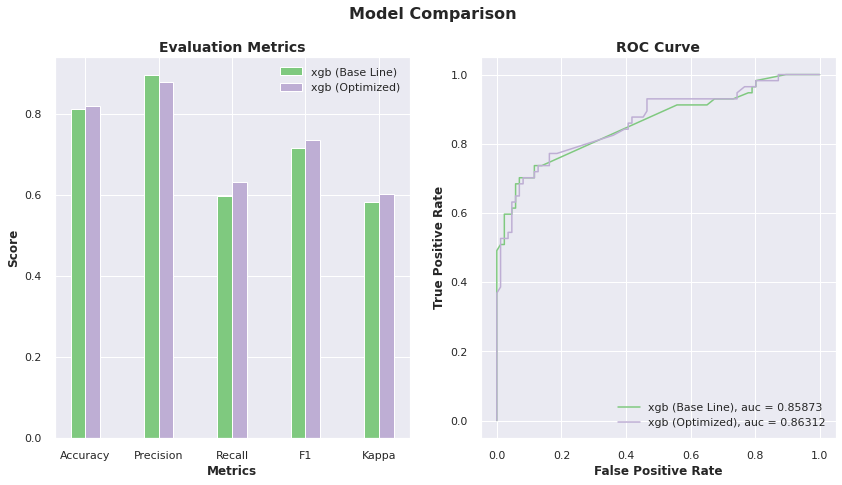

Change of 0.70% on accuracy.
Change of -1.67% on precision.
Change of 3.51% on recall.
Change of 1.89% on F1 score.
Change of 1.92% on Kappa score.
Change of 0.44% on AUC.


In [18]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
xgb_score = [xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_kappa]
best_grid_score = [best_grid_acc, best_grid_prec, best_grid_rec, best_grid_f1, best_grid_kappa]    

## Set position of bar on X axis
r1 = np.arange(len(xgb_score))
r2 = [x + barWidth for x in r1]

## Make the plot
ax1.bar(r1, xgb_score, width=barWidth, edgecolor='white', label='xgb (Base Line)')
ax1.bar(r2, best_grid_score, width=barWidth, edgecolor='white', label='xgb (Optimized)')

## Add xticks on the middle of the group bars
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 0.5) for r in range(len(xgb_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
# ax1.set_ylim(0, 1)

## Create legend & Show graphic
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(xgb_fpr, xgb_tpr, label='xgb (Base Line), auc = {:0.5f}'.format(xgb_auc))
ax2.plot(best_grid_fpr, best_grid_tpr, label='xgb (Optimized), auc = {:0.5f}'.format(best_grid_auc))

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.legend(loc=4)

plt.show()

print('Change of {:0.2f}% on accuracy.'.format(100 * (best_grid_acc - xgb_acc)))
print('Change of {:0.2f}% on precision.'.format(100 * (best_grid_prec - xgb_prec)))
print('Change of {:0.2f}% on recall.'.format(100 * (best_grid_rec - xgb_rec)))
print('Change of {:0.2f}% on F1 score.'.format(100 * (best_grid_f1 - xgb_f1)))
print('Change of {:0.2f}% on Kappa score.'.format(100 * (best_grid_kappa - xgb_kappa)))
print('Change of {:0.2f}% on AUC.'.format(100 * (best_grid_auc - xgb_auc)))

The result show that our optimized performed little bit better than the original model. The optimized models show an increase in 5 out of the 6 metrics but perform worse in the precision metrics with a decline of 1.7% from the base line model. From this result we can confidently say that our optimized model perform better than the original one.

# Output

## Saving model

We can save our model and TF-IDF vectorizer for further model reusability. This model can then be loaded on another machine to make new prediction without doing the whole training process again.

In [19]:
import joblib

# Saving model
joblib.dump(best_grid, 'Hate Speech Classifier.joblib')
joblib.dump(tfidf_vectorizer, 'Hate Speech TF-IDF Vectorizer.joblib')

['Hate Speech TF-IDF Vectorizer.joblib']

## Predict Existing Dataset

Using the trained model we can predict the expected outcome of all the row from our dataset then save it into a csv file for easier access in the future.

In [20]:
df['prediction'] = best_grid.predict(tfidf_vectorizer.transform(df1['Tweet']))
df['prediction'] = df['prediction'].apply(lambda x: 'HS' if x==1 else 'Non_HS')

# Save new dataframe into csv file
df.to_csv('Hate Speech Classification.csv', index=False)

df.head()

,Label,Tweet,prediction
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,Non_HS
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,Non_HS
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,Non_HS
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",Non_HS
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,Non_HS


## Predict New Data

We can also predict new data using the model. First, we will create a pre-processing function which combine all of our previous function and then create another function to pass the new data into our TF-IDF vectorizer and then predict it using our saved model. We will then print the prediction of the news data into the output cell.

In [22]:
input_tweet = ['dasar cina',
               'semoga pilkada ini berjalan dengan lancar']

def preProcessText(texts):
    new_texts = []
    for t in texts:
        t = tokenizeWords(t)
        t = removeUselessText(t)
        t = stemmSentence(t)
        t = replaceSlang(t)
        t = removeStopWords(t)
        t = ' '.join(t)
        new_texts.append(t)

    return new_texts

def predictNewData(tweets):
    saved_model = joblib.load('Hate Speech Classifier.joblib') 
    saved_tfidf = joblib.load('Hate Speech TF-IDF Vectorizer.joblib')

    vectorized_tweets = saved_tfidf.transform(tweets)
    input_prediction = saved_model.predict(vectorized_tweets)

    for i in range(len(input_tweet)):
        if input_prediction[i]==1:
            print('Input text:\n', 
                input_tweet[i], 
                '\nPrediction: \nThe tweets is identified as Hate Speech!\n')
        else:
            print('Input text:\n', 
                input_tweet[i], 
                "\nPrediction: \nThe tweets is not a Hate Speech. Let's keep it that way.\n")
            
predictNewData(input_tweet)

Input text:
 dasar cina 
Prediction: 
The tweets is identified as Hate Speech!

Input text:
 semoga pilkada ini berjalan dengan lancar 
Prediction: 
The tweets is not a Hate Speech. Let's keep it that way.



# Conclusion

We can see that our model did decently on classifying the data. But there are still some weakness on our model, especially shown on the recall metric where we only get about 60%. This means that our model are only able to detect 60% of potential hate speech and miss the other 40%. The result did improve slightly after using `GridSearchCV` but still not enough improvement happens on the recall score. We can improve this by cleaning our data more thoroughly because our current pre-processing  still allow some junk words, especially a few words that are jumbled into one word and also some slang words.

# References

1. Telkom Digital Talent Incubator - Data Scientist Module 7 (Text Mining)
2. [Scikit-learn Documentation](https://scikit-learn.org/stable/index.html)
3. [The 5 Classification Evaluation metrics every Data Scientist must know](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
4. [The Python Graph Gallery - Grouped Bar Plot](https://python-graph-gallery.com/11-grouped-barplot/)
5. [Digital Business Ecosystem Research Center - Text Miining (GitHub)](https://github.com/rc-dbe/dti-tm)
6. [Dhitology - Social Media Analytics (GitHub)](https://github.com/dhitology/sma-r)
7. [Gradient Boosting Classifiers in Python with Scikit-Learn](https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/)
8. [The Dataset for Hate Speech Detection in the Indonesian Language (Bahasa Indonesia)](https://github.com/ialfina/id-hatespeech-detection/)